In [4]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [5]:
from ggmodel_dev.graphmodel import GraphModel, concatenate_graph_specs, merge_models
from ggmodel_dev.validation import score_model, plot_diagnostic

from data_utils.database import select_dataset
from data_utils.utils import get_X_y_from_data, data_dict_from_df_tables

import pandas as pd
import numpy as np

# Refactored model

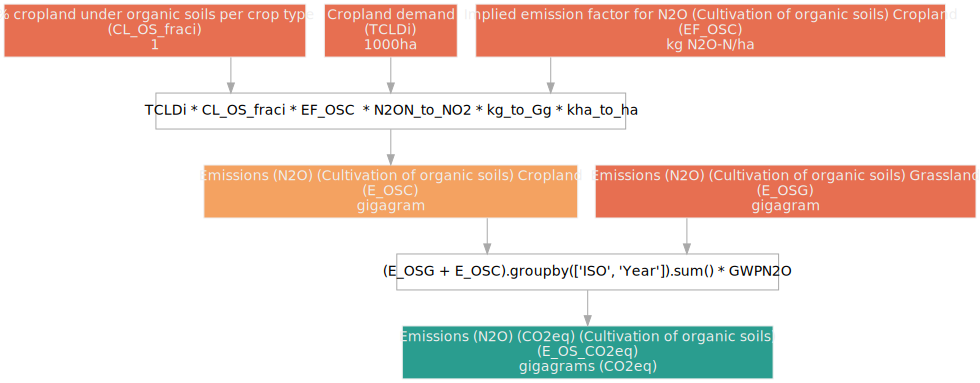

In [6]:
#CO2eq emissions from the cultivation of organic soils
#dataset cultivation of organic soils: http://www.fao.org/faostat/en/#data/GV 
GWPN2O = 310
N2ON_to_NO2 = 1.57
kg_to_Gg = 1e-6
kha_to_ha = 1e-3


Emissions_organic_soils = {

    'CL_OS_fraci': {'type': 'input', # to be precomupted in the database
              'name': '% cropland under organic soils per crop type',
              'unit': '1',
              },

    'E_OSG': {'type': 'input',
              'unit': 'gigagram',
              'name': 'Emissions (N2O) (Cultivation of organic soils) Grassland'},

    'E_OS_CO2eq': {'type': 'output',
              'name': 'Emissions (N2O) (CO2eq) (Cultivation of organic soils)',
              'unit': 'gigagrams (CO2eq)',
              'computation': lambda E_OSG, E_OSC, **kwargs: (E_OSG + E_OSC).groupby(['ISO', 'Year']).sum() * GWPN2O
              },
    'TCLDi': {'type': 'input',
             'unit': '1000ha',
             'name': 'Cropland demand'},
    'EF_OSC': {'type': 'input',
             'unit': 'kg N2O-N/ha',
             'name': 'Implied emission factor for N2O (Cultivation of organic soils) Cropland'},
    'E_OSC': {'type': 'variable',
              'name': 'Emissions (N2O) (Cultivation of organic soils) Cropland',
              'unit': 'gigagram',
              'computation': lambda CL_OS_fraci,TCLDi, EF_OSC, **kwargs:  TCLDi * CL_OS_fraci * EF_OSC  * N2ON_to_NO2 * kg_to_Gg * kha_to_ha
             } 
}


E_OS_model = GraphModel(Emissions_organic_soils)

E_OS_model.draw()

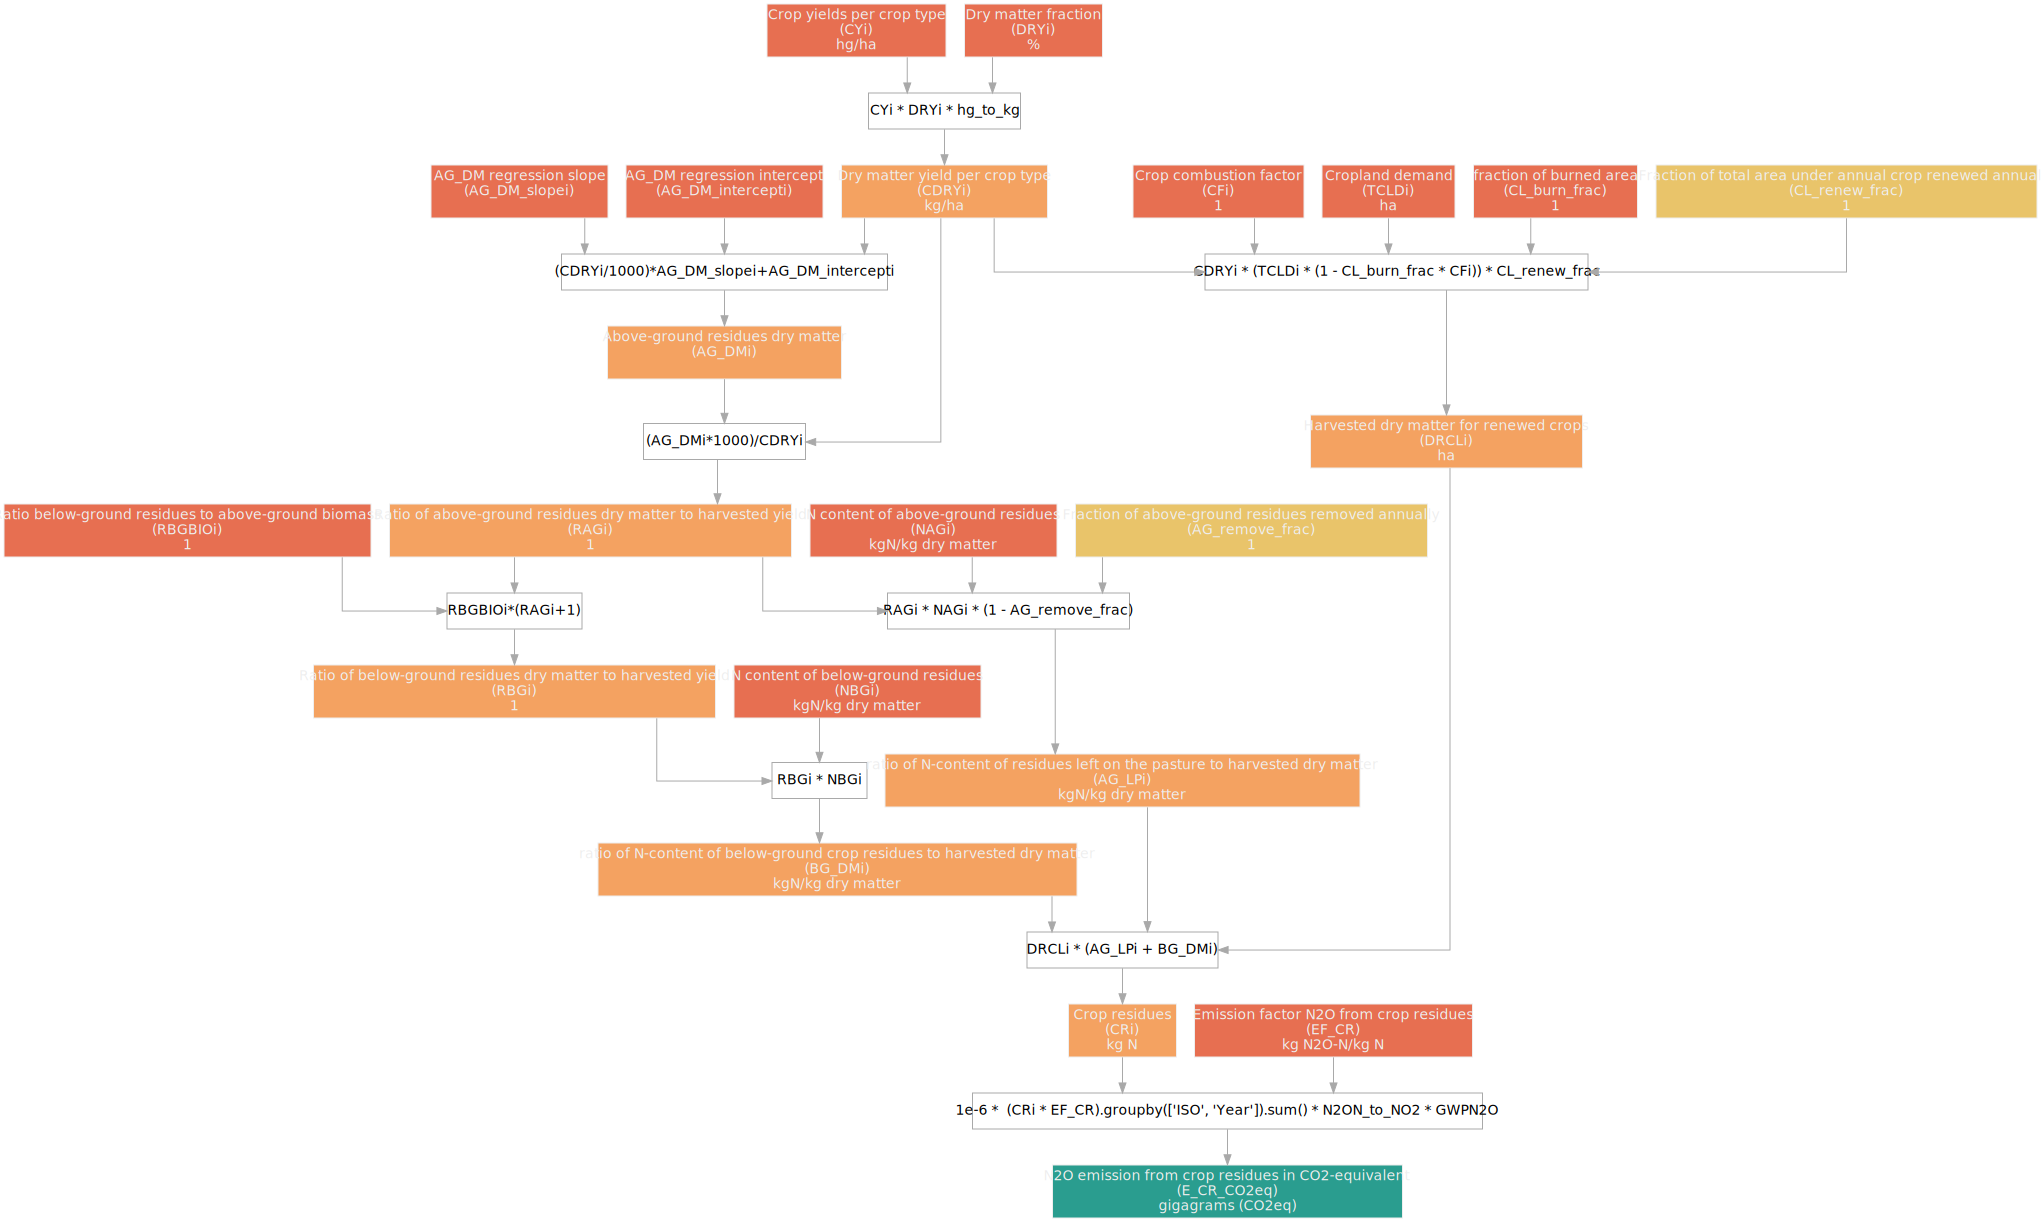

In [29]:

#CO2eq emissions from crop residues
#methodology / tables with parameters: http://www.fao.org/climatechange/41521-0373071b6020a176718f15891d3387559.pdf from table 45.
#only the following crops are assumed to have residue biomass:
Residue_crops = ['Barley', 'Beans, Dry', 'Maize','Millet','Oats','Potatoes','Rice, Paddy','Rye', 'Sorghum','Soybeans','Wheat']
#TCropDi[Residue_crops]
#FPi[Residue_crops]


hg_to_kg = 1e-1
GWPN2O = 310
N2ON_to_NO2 = 1.57
kg_to_Gg = 1e-6
kha_to_ha = 1e-3
GWPCH4 = 21
tonnes_to_kg = 1e3
g_to_Gg = 1e-9


residue_emissions = {
    'CYi': {'type': 'input',
             'unit': 'hg/ha',
             'name': 'Crop yields per crop type'},
    'DRYi': {'type': 'input',
              'unit': '%',
              'name': 'Dry matter fraction'},
    'CDRYi': {'type': 'variable',
              'name': 'Dry matter yield per crop type',
              'unit': 'kg/ha',
              'computation': lambda CYi, DRYi, **kwargs: CYi * DRYi * hg_to_kg
              },
    'AG_DM_slopei': {'type': 'input',
              'unit': '',
              'name': 'AG_DM regression slope'},
    'AG_DM_intercepti': {'type': 'input',
              'unit': '',
              'name': 'AG_DM regression intercept'},
    'AG_DMi': {'type': 'variable',
              'name': 'Above-ground residues dry matter',
              'unit': '',
              'computation': lambda CDRYi, AG_DM_slopei, AG_DM_intercepti, **kwargs: (CDRYi/1000)*AG_DM_slopei+AG_DM_intercepti
              },
    'RAGi': {'type': 'variable',
              'name': 'Ratio of above-ground residues dry matter to harvested yield',
              'unit': '1',
              'computation': lambda AG_DMi,CDRYi, **kwargs: (AG_DMi*1000)/CDRYi
              },
    'RBGBIOi': {'type': 'input',
              'unit': '1',
              'name': 'Ratio below-ground residues to above-ground biomass'},
    'RBGi': {'type': 'variable',
              'name': 'Ratio of below-ground residues dry matter to harvested yield',
              'unit': '1',
              'computation': lambda RAGi,RBGBIOi, **kwargs: RBGBIOi*(RAGi+1)
              },
    'TCLDi': {'type': 'input',
              'unit': 'ha',
              'name': 'Cropland demand'}, # add selection of crops
    'CL_burn_frac': {'type': 'input',
                     'unit': '1',
                     'name': 'fraction of burned area'},
    'CL_renew_frac': {'type': 'parameter',
              'unit': '1',
              'name': 'Fraction of total area under annual crop renewed annually'},
    'AG_remove_frac': {'type': 'parameter',
              'unit': '1',
              'name': 'Fraction of above-ground residues removed annually'},
    'NAGi': {'type': 'input',
              'unit': 'kgN/kg dry matter',
              'name': 'N content of above-ground residues'},
    'NBGi': {'type': 'input',
              'unit': 'kgN/kg dry matter',
              'name': 'N content of below-ground residues'},

    'CFi': {'type': 'input',
              'unit': '1',
              'name': 'Crop combustion factor'},
    
   'DRCLi': {'type': 'variable',
              'name': 'Harvested dry matter for renewed crops',
              'unit': 'ha',
              'computation': lambda TCLDi,CDRYi,CFi,CL_renew_frac, CL_burn_frac, **kwargs: CDRYi * (TCLDi * (1 - CL_burn_frac * CFi)) * CL_renew_frac
              },
   'AG_LPi': {'type': 'variable',
              'name': 'ratio of N-content of residues left on the pasture to harvested dry matter',
              'unit': 'kgN/kg dry matter',
              'computation': lambda RAGi, NAGi, AG_remove_frac, **kwargs: RAGi * NAGi * (1 - AG_remove_frac)
              },
   'BG_DMi': {'type': 'variable',
              'name': 'ratio of N-content of below-ground crop residues to harvested dry matter',
              'unit': 'kgN/kg dry matter',
              'computation': lambda RBGi, NBGi, **kwargs: RBGi * NBGi
               },
    'CRi': {'type': 'variable',
              'name': 'Crop residues',
              'unit': 'kg N',
              'computation': lambda DRCLi, AG_LPi, BG_DMi, **kwargs: DRCLi * (AG_LPi + BG_DMi)
              },
#     'CRi': {'type': 'variable',
#               'name': 'Crop residues',
#               'unit': 'kg N',
#               'computation': lambda TCLDi,CDRYi,CFi,NBGi,NAGi,RAGi,CL_renew_frac,AG_remove_frac, CL_burn_frac, RBGi, **kwargs: CDRYi * (TCLDi * (1 - CL_burn_frac * CFi)) * CL_renew_frac * (RAGi * NAGi * (1 - AG_remove_frac) + RBGi * NBGi)
#               },
    'EF_CR': {'type': 'input',
             'unit': 'kg N2O-N/kg N',
             'name': 'Emission factor N2O from crop residues'},
    'E_CR_CO2eq': {'type': 'output',
              'name': 'N2O emission from crop residues in CO2-equivalent',
              'unit': 'gigagrams (CO2eq)',
              'computation': lambda CRi, EF_CR, **kwargs: 1e-6 *  (CRi * EF_CR).groupby(['ISO', 'Year']).sum() * N2ON_to_NO2 * GWPN2O
              },
}


E_CR_model = GraphModel(residue_emissions)

E_CR_model.draw()

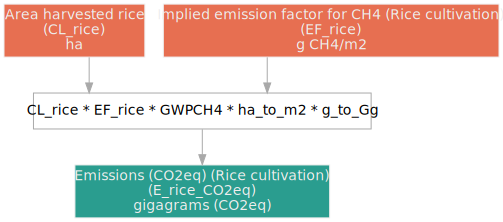

In [30]:
GWPCH4 = 21
g_to_Gg = 1e-6
ha_to_m2 = 1e5

rice_emissions = {
    'CL_rice': {'type': 'input',
             'unit': 'ha',
             'name': 'Area harvested rice'},
    'EF_rice': {'type': 'input',
              'unit': 'g CH4/m2',
              'name': 'Implied emission factor for CH4 (Rice cultivation)'},
    'E_rice_CO2eq': {'type': 'output',
              'name': 'Emissions (CO2eq) (Rice cultivation)',
              'unit': 'gigagrams (CO2eq)',
              'computation': lambda CL_rice, EF_rice, **kwargs: CL_rice * EF_rice * GWPCH4 * ha_to_m2 * g_to_Gg
              },
}


E_rice_model = GraphModel(rice_emissions)


E_rice_model.draw()

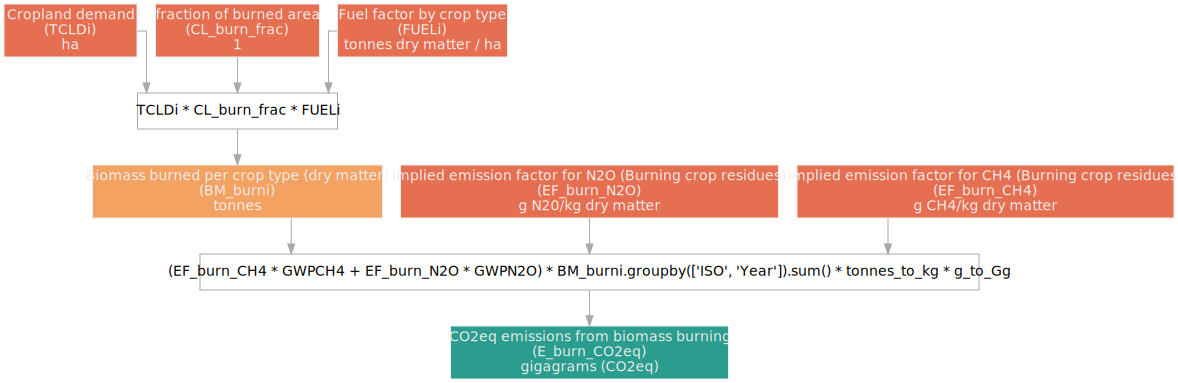

In [31]:
#CO2eq emissions from burning biomass/crop residues
#http://www.fao.org/faostat/en/#data/GB
GWPN2O = 310
N2ON_to_NO2 = 1.57
kg_to_Gg = 1e-6
kha_to_ha = 1e-3
GWPCH4 = 21
tonnes_to_kg = 1e3
g_to_Gg = 1e-9

Crops_burning = ['Wheat','Maize','Rice','Sugarcane']

emissions_burning = {
    'TCLDi': {'type': 'input',
                  'unit': 'ha',
                  'name': 'Cropland demand'}, # add selection of crops
    'CL_burn_frac': {'type': 'input',
                     'unit': '1',
                     'name': 'fraction of burned area'},

    'FUELi': {'type': 'input',
              'unit': 'tonnes dry matter / ha',
              'name': 'Fuel factor by crop type'},

    'BM_burni': {'type': 'variable',
              'name': 'Biomass burned per crop type (dry matter)',
              'unit': 'tonnes',
              'computation': lambda TCLDi, CL_burn_frac, FUELi, **kwargs: TCLDi * CL_burn_frac * FUELi
              },

    'EF_burn_N2O': {'type': 'input',
              'unit': 'g N20/kg dry matter',
              'name': 'Implied emission factor for N2O (Burning crop residues)'},

    'EF_burn_CH4': {'type': 'input',
              'unit': 'g CH4/kg dry matter',
              'name': 'Implied emission factor for CH4 (Burning crop residues)'},
              
    'E_burn_CO2eq': {'type': 'output',
              'name': 'CO2eq emissions from biomass burning',
              'unit': 'gigagrams (CO2eq)',
              'computation': lambda EF_burn_N2O, EF_burn_CH4, BM_burni, **kwargs: (EF_burn_CH4 * GWPCH4 + EF_burn_N2O * GWPN2O) * BM_burni.groupby(['ISO', 'Year']).sum() * tonnes_to_kg * g_to_Gg
              }, 

}


E_burn_model = GraphModel(emissions_burning)

E_burn_model.draw()

In [32]:
OE_nodes = {
                  
    'E_burn_CO2eq': {'type': 'input',
              'name': 'CO2eq emissions from biomass burning',
              'unit': 'gigagrams (CO2eq)',
              }, 
    'E_rice_CO2eq': {'type': 'input',
              'name': 'Emissions (CO2eq) (Rice cultivation)',
              'unit': 'gigagrams (CO2eq)',
              },
    'E_CR_CO2eq': {'type': 'input',
          'name': 'N2O emission from crop residues in CO2-equivalent',
          'unit': 'gigagrams (CO2eq)',
          },
    
    'E_OS_CO2eq': {'type': 'input',
              'name': 'Emissions (N2O) (CO2eq) (Cultivation of organic soils)',
              'unit': 'gigagrams (CO2eq)',
              },   
    'OE_CO2eq':{
        'type': 'output',
        'name': 'Emissions other',
        'unit': 'gigagrams (CO2eq)',
        'computation': lambda E_burn_CO2eq, E_rice_CO2eq, E_CR_CO2eq, E_OS_CO2eq, **kwargs: E_rice_CO2eq + E_burn_CO2eq + E_CR_CO2eq + E_OS_CO2eq
    }
    
}

E_other_model = GraphModel(OE_nodes)

In [33]:
model = merge_models([E_other_model, E_burn_model, E_rice_model, E_CR_model, E_OS_model])

In [39]:
model.draw().render('Other_Emission.pdf')

'Other_Emission.pdf.pdf'

In [35]:
model.summary_df.query('type in ["input", "parameter"]')

,name,type,unit,computation
id,,,,
TCLDi,Cropland demand,input,1000ha,NaN
CL_burn_frac,fraction of burned area,input,1,NaN
FUELi,Fuel factor by crop type,input,tonnes dry matter / ha,NaN
EF_burn_N2O,Implied emission factor for N2O (Burning crop ...,input,g N20/kg dry matter,NaN
EF_burn_CH4,Implied emission factor for CH4 (Burning crop ...,input,g CH4/kg dry matter,NaN
CL_rice,Area harvested rice,input,ha,NaN
EF_rice,Implied emission factor for CH4 (Rice cultivat...,input,g CH4/m2,NaN
CYi,Crop yields per crop type,input,hg/ha,NaN
DRYi,Dry matter fraction,input,%,NaN


In [37]:
model.summary_df

,name,type,unit,computation
id,,,,
E_burn_CO2eq,CO2eq emissions from biomass burning,variable,gigagrams (CO2eq),(EF_burn_CH4 * GWPCH4 + EF_burn_N2O * GWPN2O) ...
E_rice_CO2eq,Emissions (CO2eq) (Rice cultivation),variable,gigagrams (CO2eq),CL_rice * EF_rice * GWPCH4 * ha_to_m2 * g_to_Gg
E_CR_CO2eq,N2O emission from crop residues in CO2-equivalent,variable,gigagrams (CO2eq),"1e-6 * (CRi * EF_CR).groupby(['ISO', 'Year'])..."
E_OS_CO2eq,Emissions (N2O) (CO2eq) (Cultivation of organi...,variable,gigagrams (CO2eq),"(E_OSG + E_OSC).groupby(['ISO', 'Year']).sum()..."
OE_CO2eq,Emissions other,output,gigagrams (CO2eq),E_rice_CO2eq + E_burn_CO2eq + E_CR_CO2eq + E_O...
TCLDi,Cropland demand,input,1000ha,NaN
CL_burn_frac,fraction of burned area,input,1,NaN
FUELi,Fuel factor by crop type,input,tonnes dry matter / ha,NaN
BM_burni,Biomass burned per crop type (dry matter),variable,tonnes,TCLDi * CL_burn_frac * FUELi
